# Time series of exchange rate MXN-USD

## Modules

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import convolve, fftconvolve
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

## Data

In [2]:
data= pd.read_csv("VRodCDatosTcamNomAgo76.csv",  header=None)
data.rename(columns={0:'Value'}, inplace=True)

### Get date

In [3]:
data["Date"]= list(pd.date_range(start='1976-08-01', periods=len(data), freq='M'))
data.set_index('Date', inplace=True)

## Preprossesing

In [4]:
df= data.copy()

### Log transformation

In [5]:
df["LogValue"]= df["Value"].apply(lambda x: np.log(x))

In [6]:
df["AuxDate"]= df.index

### Visualization

[Text(0.5, 1.0, 'Time series exchange')]

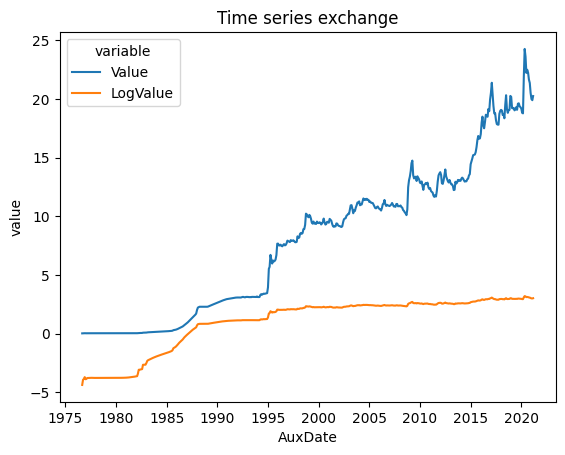

In [7]:
sns.lineplot(x='AuxDate', y='value', hue='variable',data=pd.melt(df, ['AuxDate'])).set(title='Time series exchange')

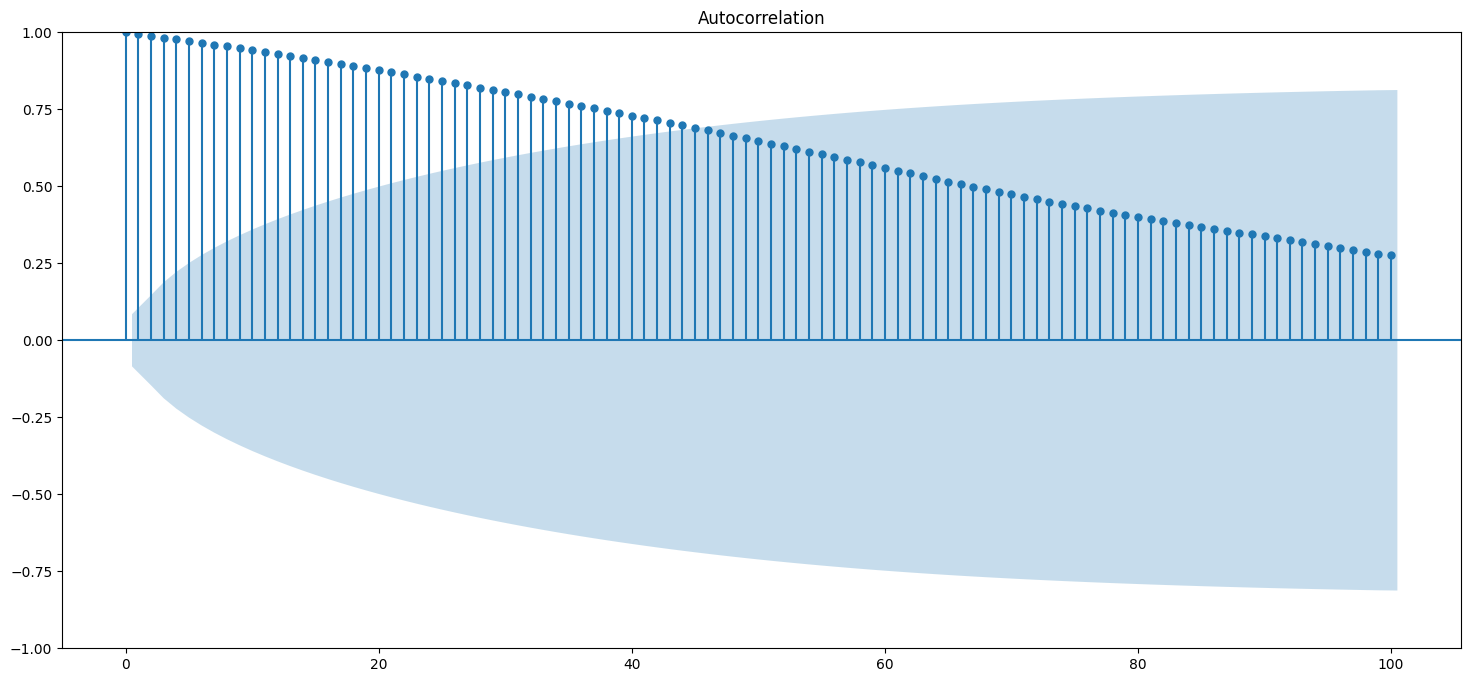

In [8]:
fig=plot_acf(df["LogValue"], lags=100)
fig.set_size_inches(18.05, 8)
plt.show()

### Create dummies

In [9]:
def DummiePulse(i,n):
    ls=[0 for x in range(n)]
    ls[i]= 1
    return ls
def DummieLevel(i,n):
    ls=[1 if x>i else 0 for x in range(n) ]
    return ls
def DummieTendency(i,n):
    ls=[0 if x<i else x-i+1 for x in range(n)]
    return ls

In [10]:
df["Ago76P"] = DummiePulse(0, len(df))

In [11]:
df["Jun77L"] =DummieLevel(9,len(df))
df["Ene95L"] =DummieLevel(220,len(df))

In [12]:
df["Nv81T"]=DummieTendency(63,len(df))
df["Ene88T"]= DummieTendency(137, len(df))

In [13]:
df["Time"]= [x+1 for x in range(len(df))]

## Modeling

### Get tendency

In [14]:
X=df[["Time", "Ago76P", "Jun77L", "Nv81T", "Ene88T", "Ene95L"]]
y= df["LogValue"]

In [15]:
X = sm.add_constant(X)

In [16]:
model= sm.OLS(y,X).fit()

In [17]:
df["Tendency"]=model.predict(X)
df["W"]= df["LogValue"]-df["Tendency"]

#### Plot without tendency

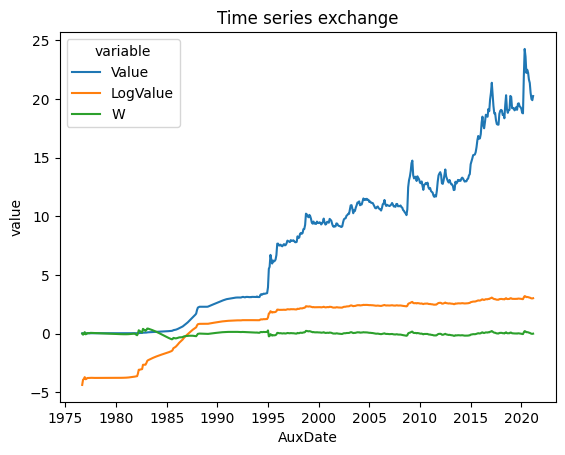

In [18]:
g=sns.lineplot(x='AuxDate', y='value', hue='variable',data=pd.melt(df,id_vars=['AuxDate'],value_vars=["Value", "LogValue", "W"] ))
g.set(title='Time series exchange')
plt.show()

## Filters

In [19]:
df_filters= df[["AuxDate", "W"]].copy()

Convulucion 1/1 3


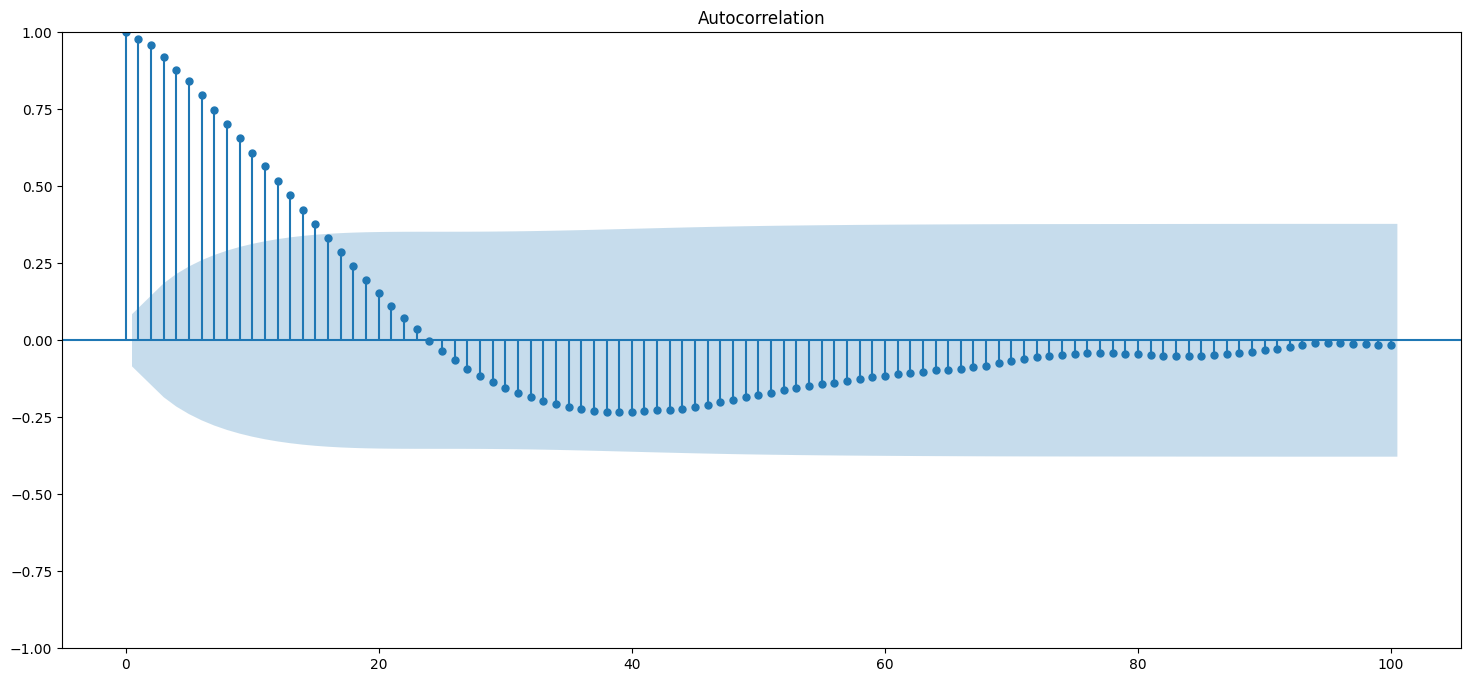

Convulucion 1/1 4


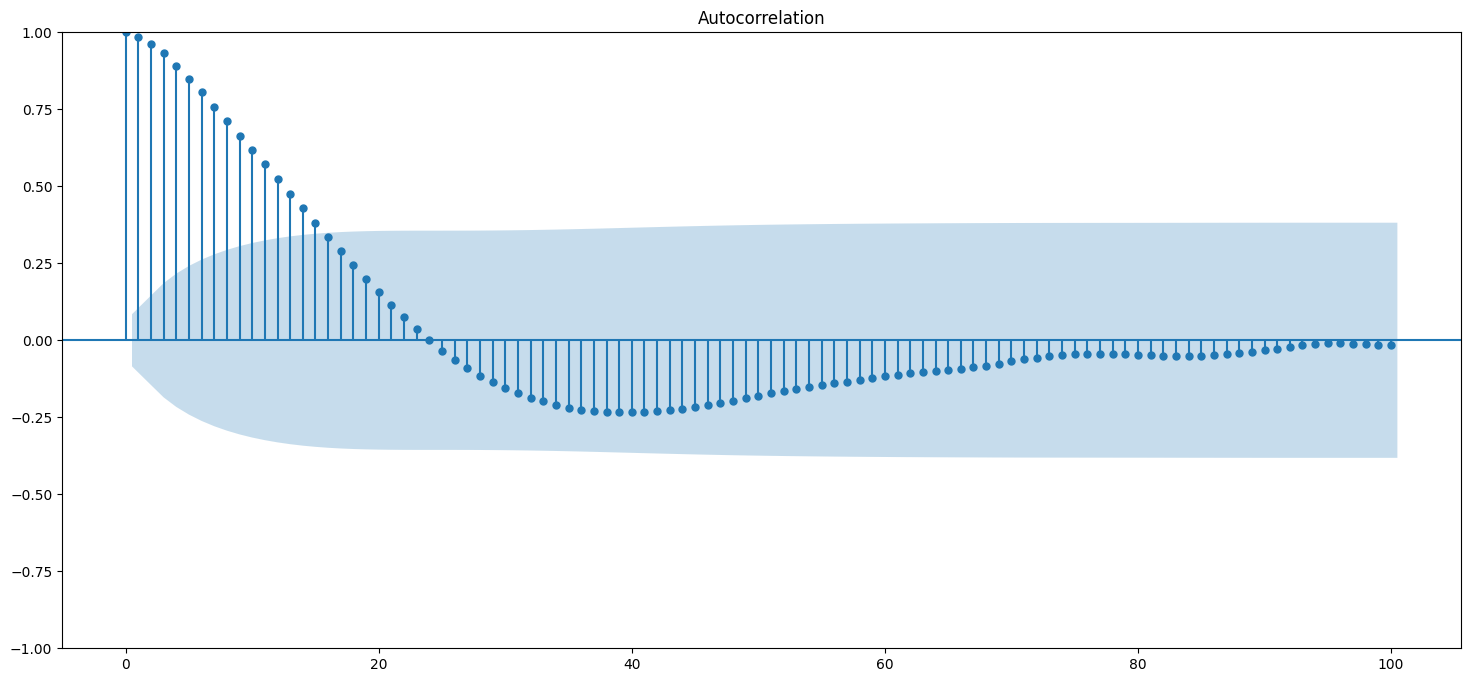

Convulucion 1/1 5


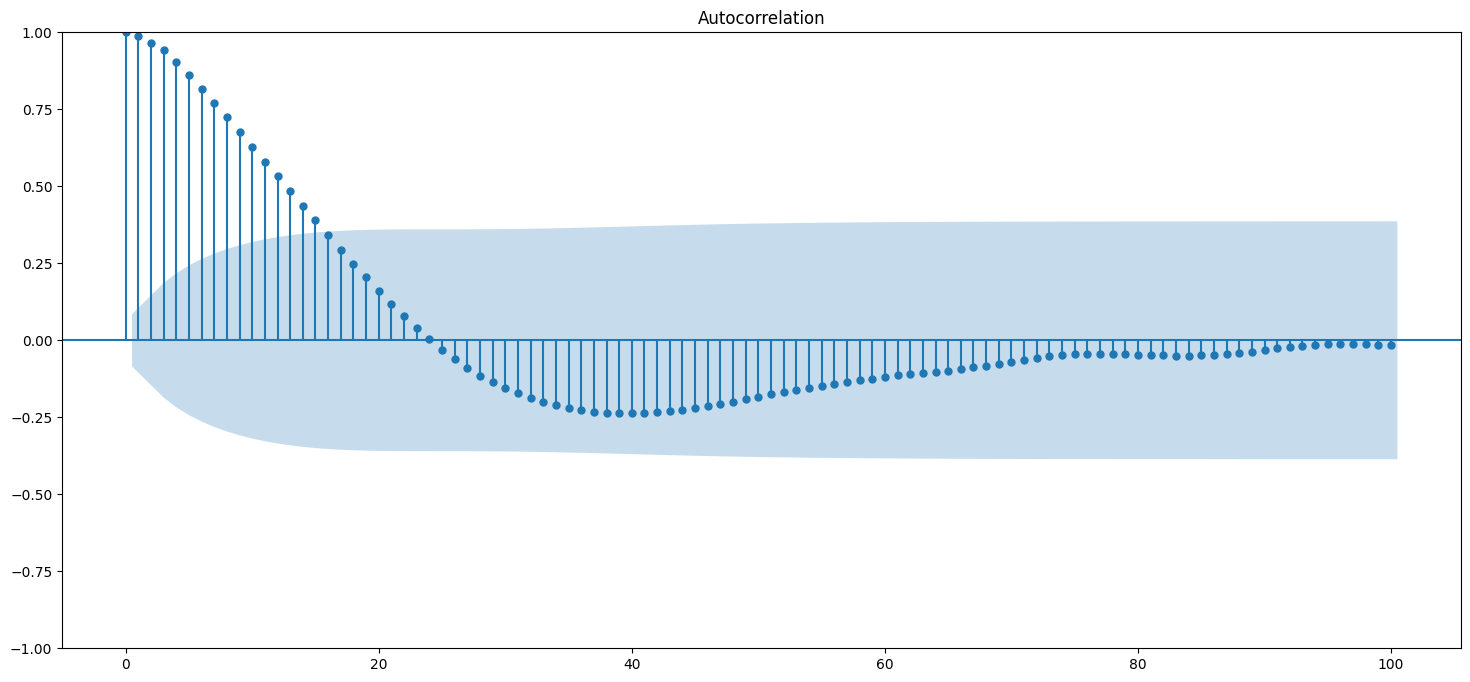

Convulucion 1/1 6


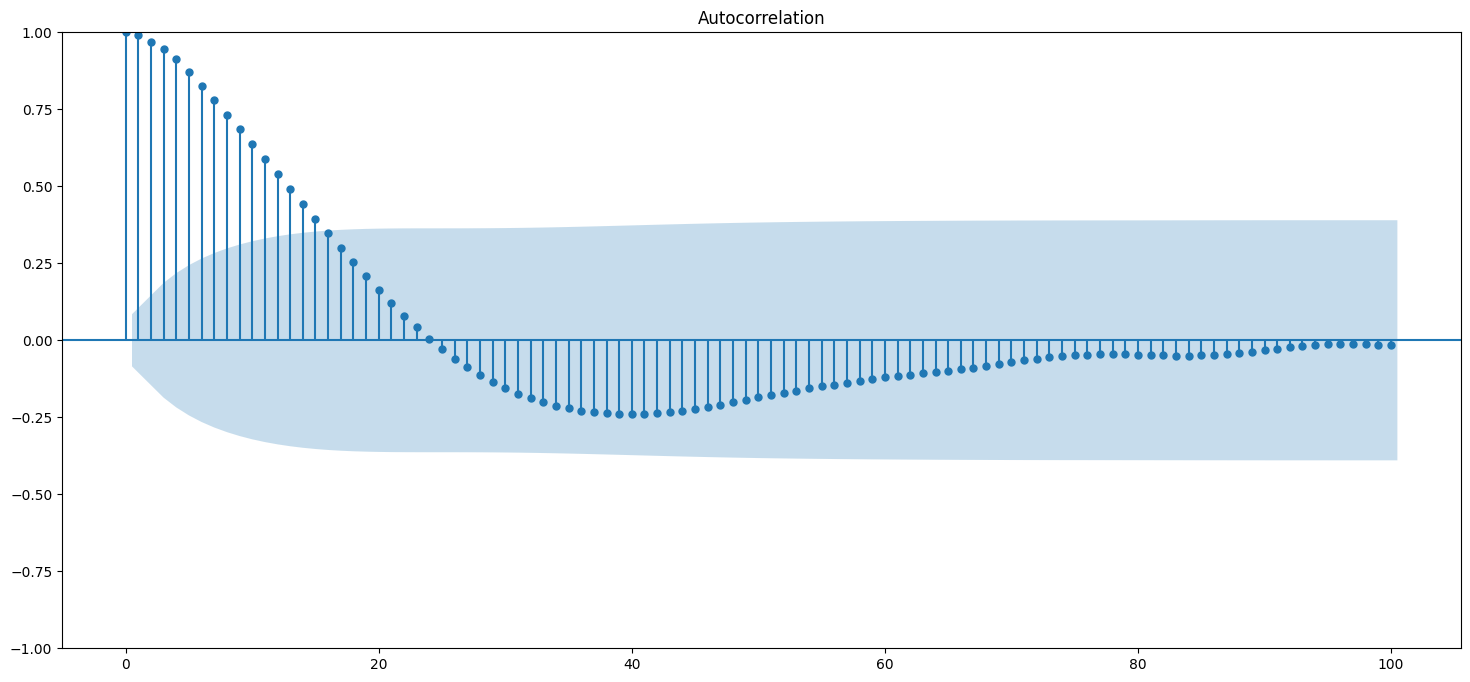

Convulucion 1/2 3


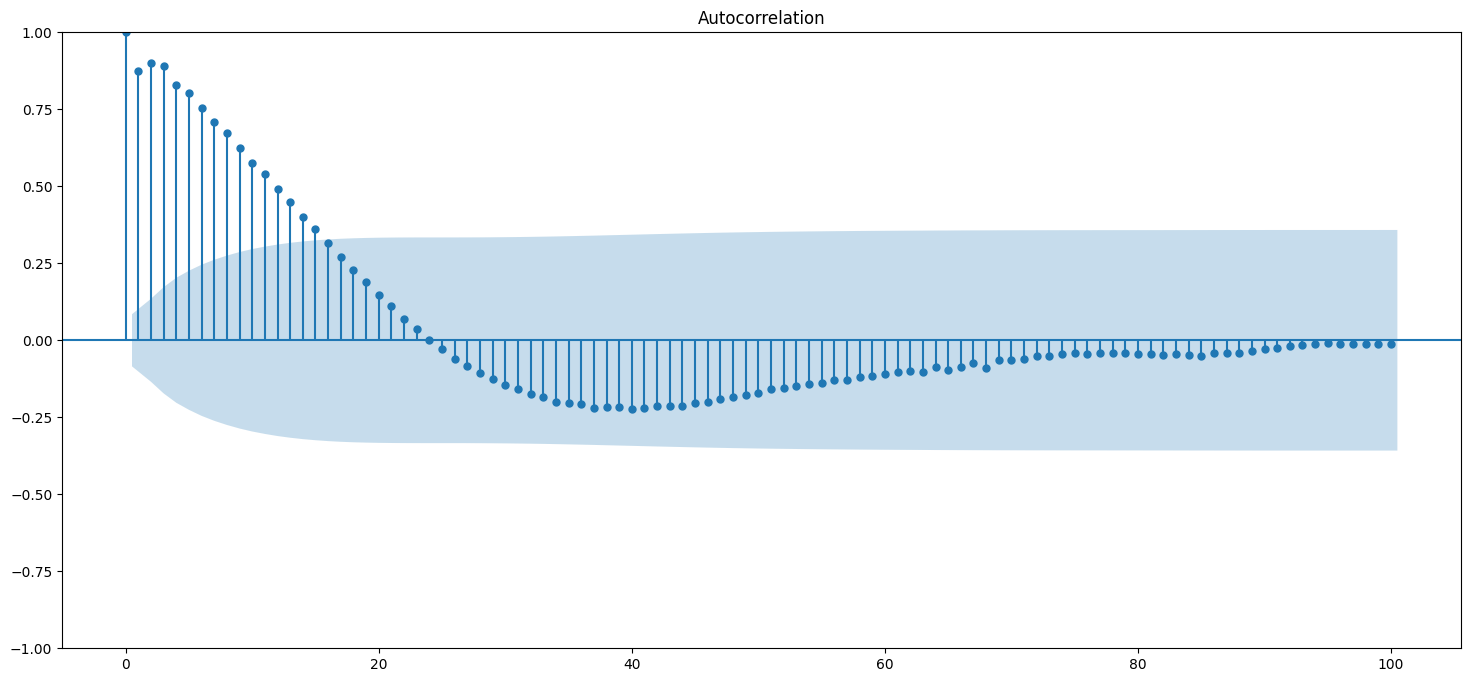

Convulucion 1/2 4


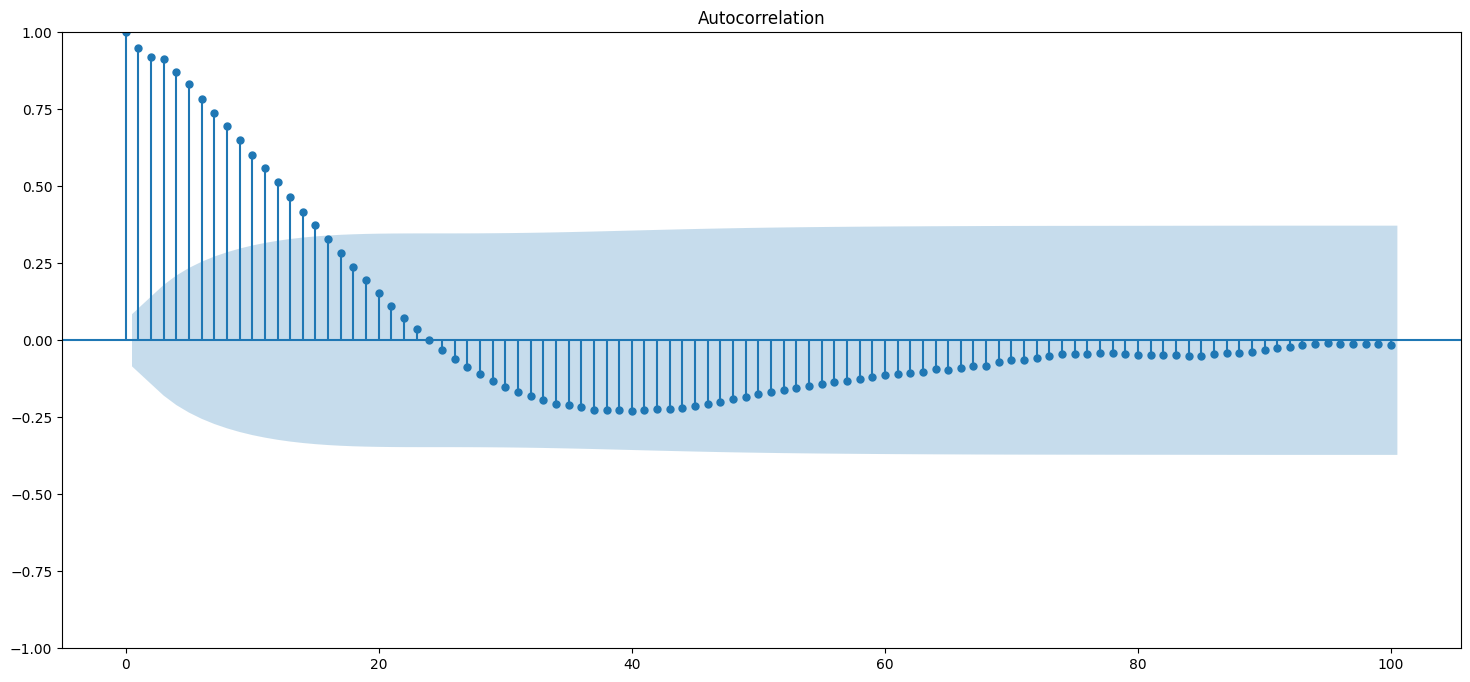

Convulucion 1/2 5


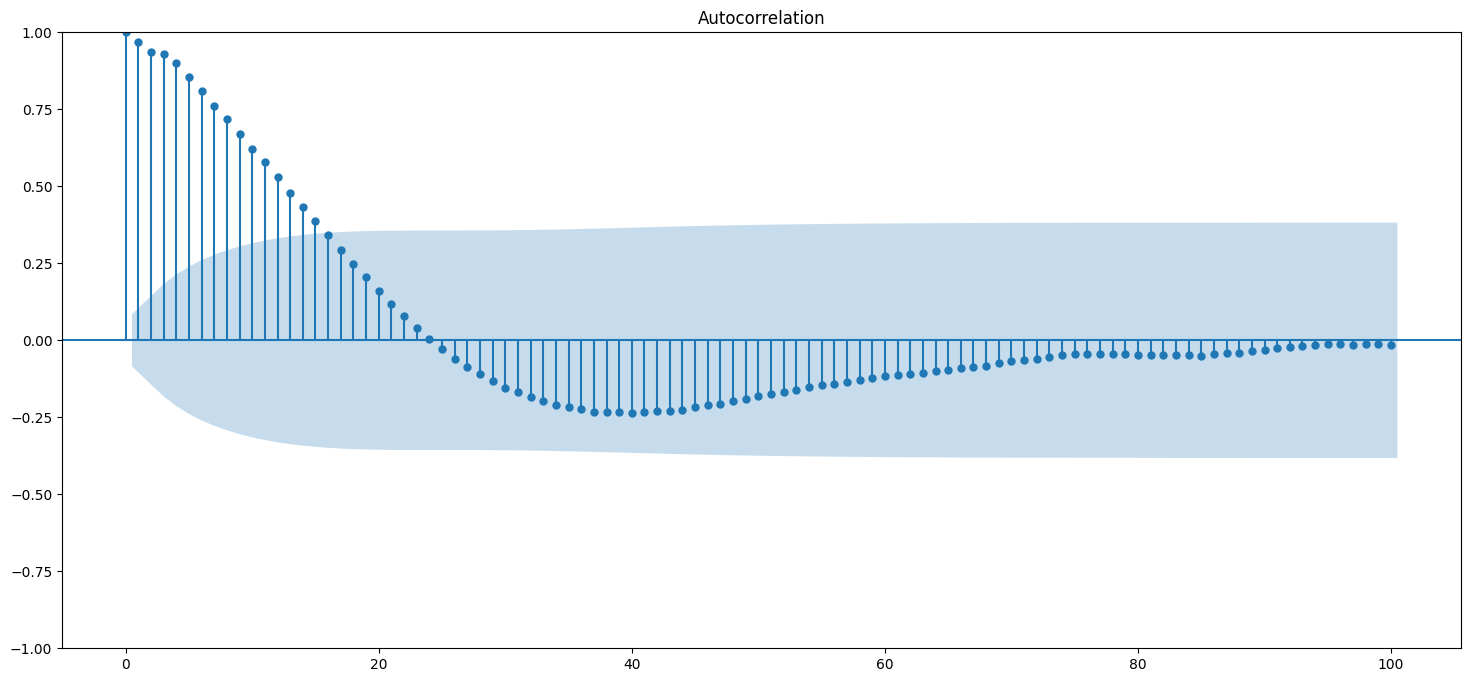

Convulucion 1/2 6


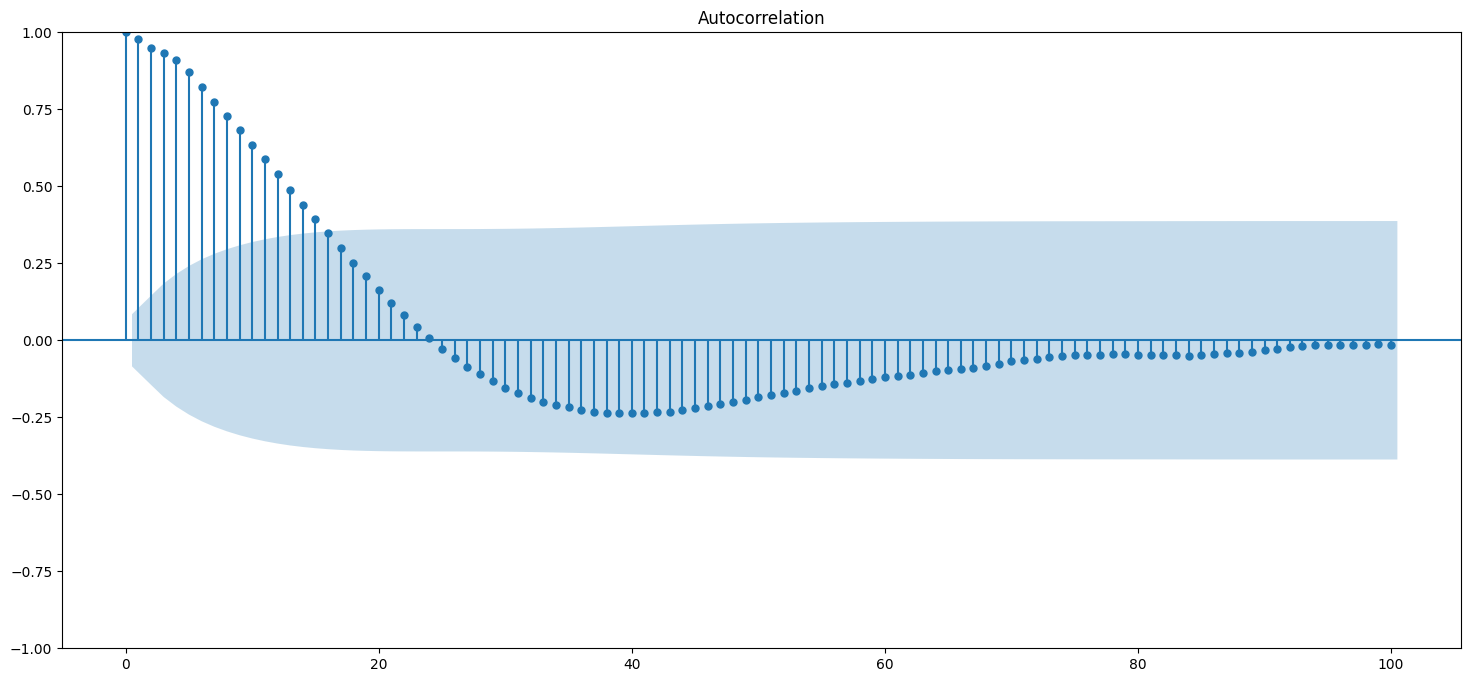

Convulucion 1/3 3


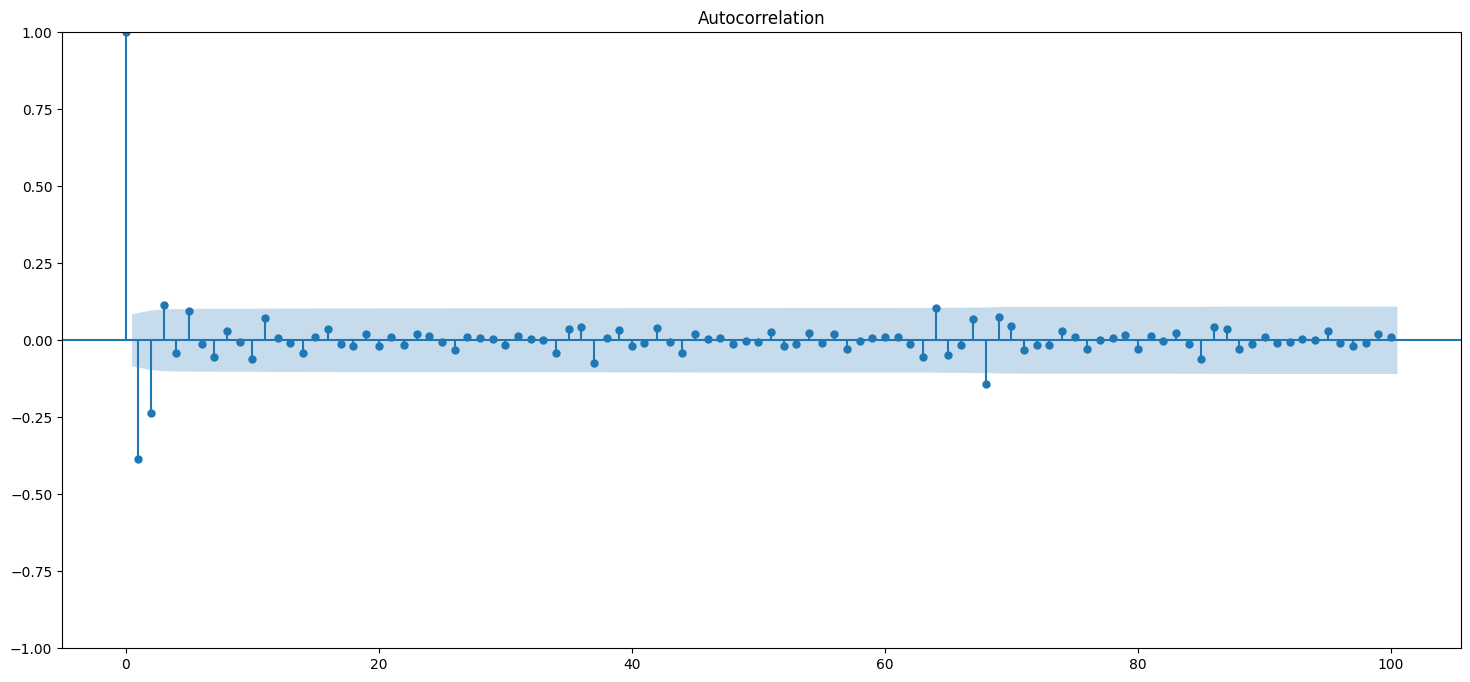

Convulucion 1/3 4


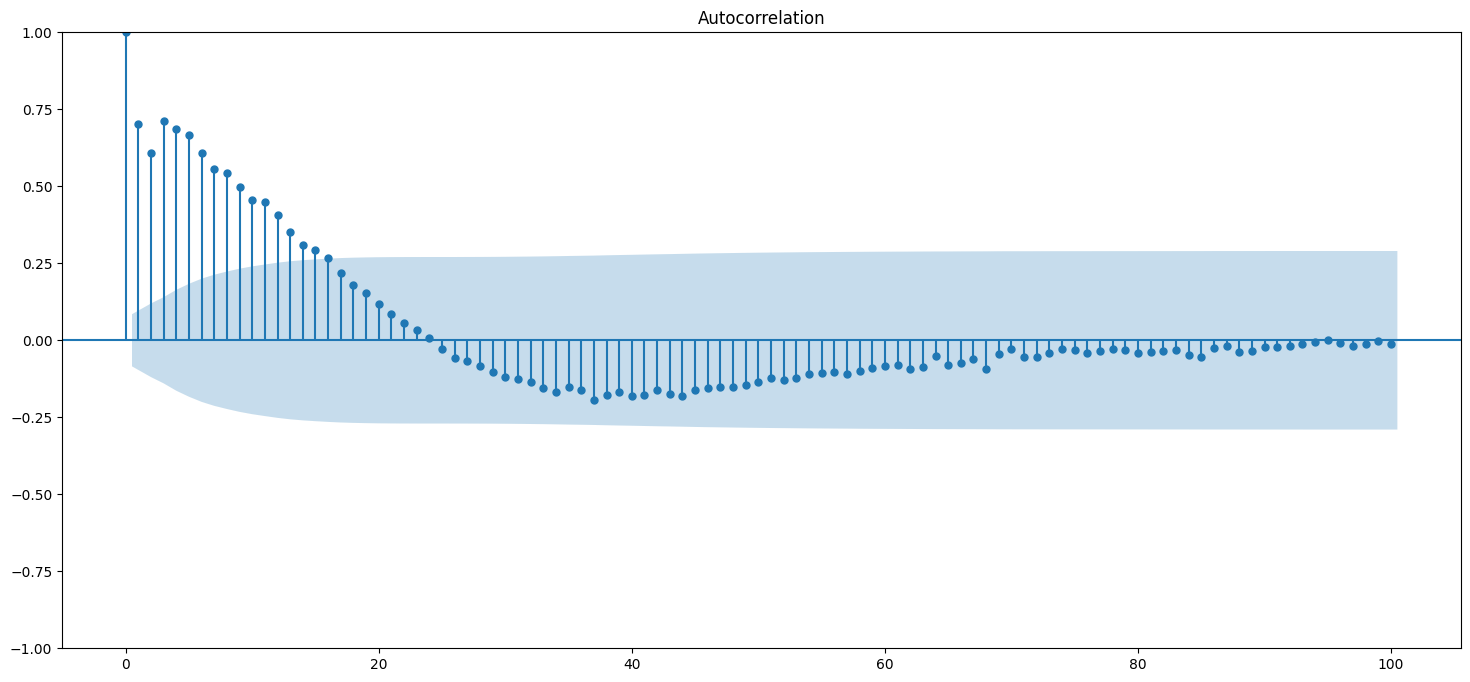

Convulucion 1/3 5


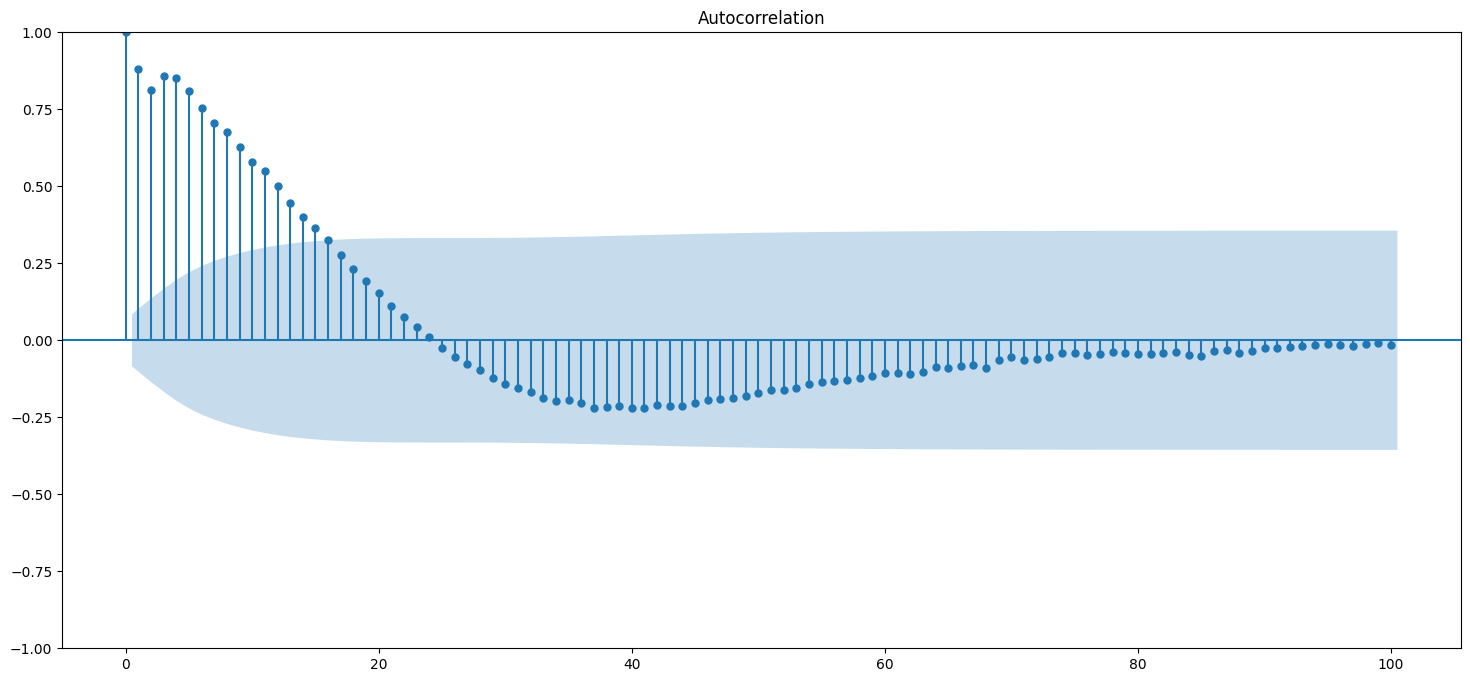

Convulucion 1/3 6


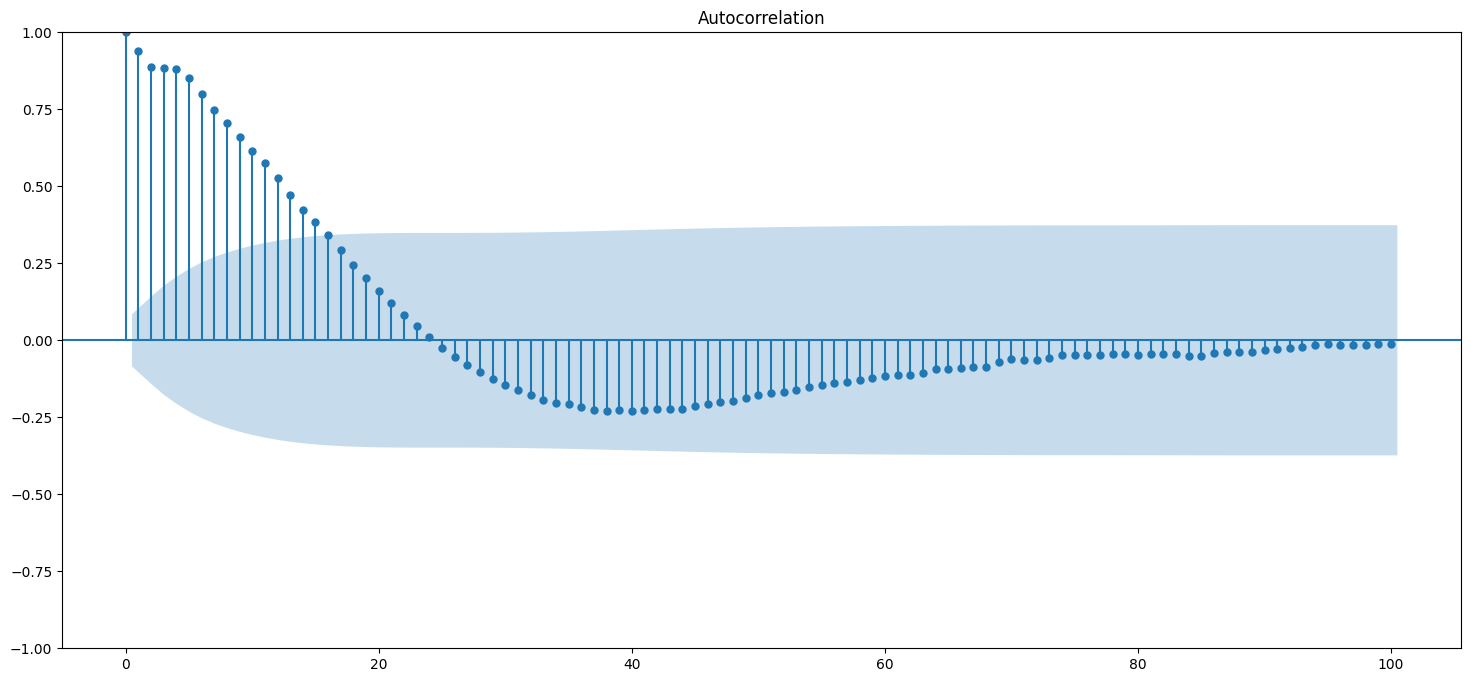

Convulucion 1/4 3


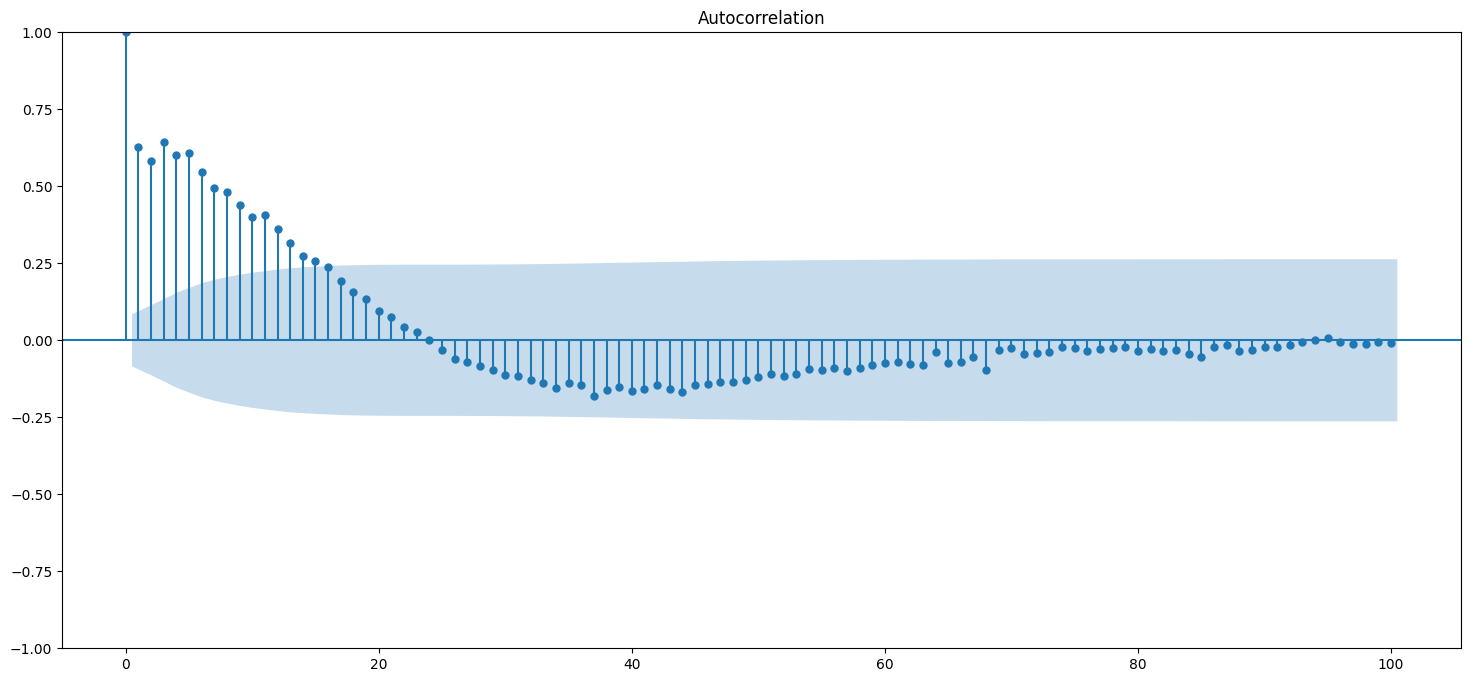

Convulucion 1/4 4


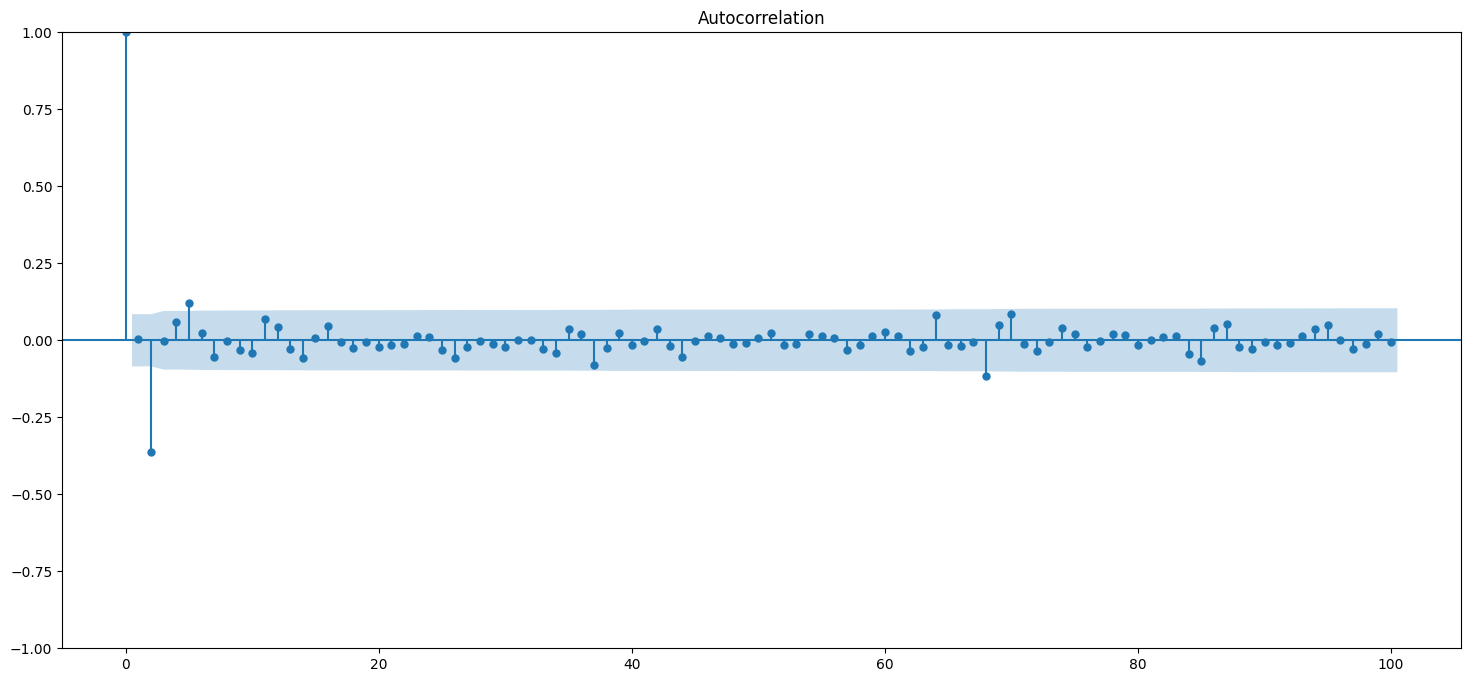

Convulucion 1/4 5


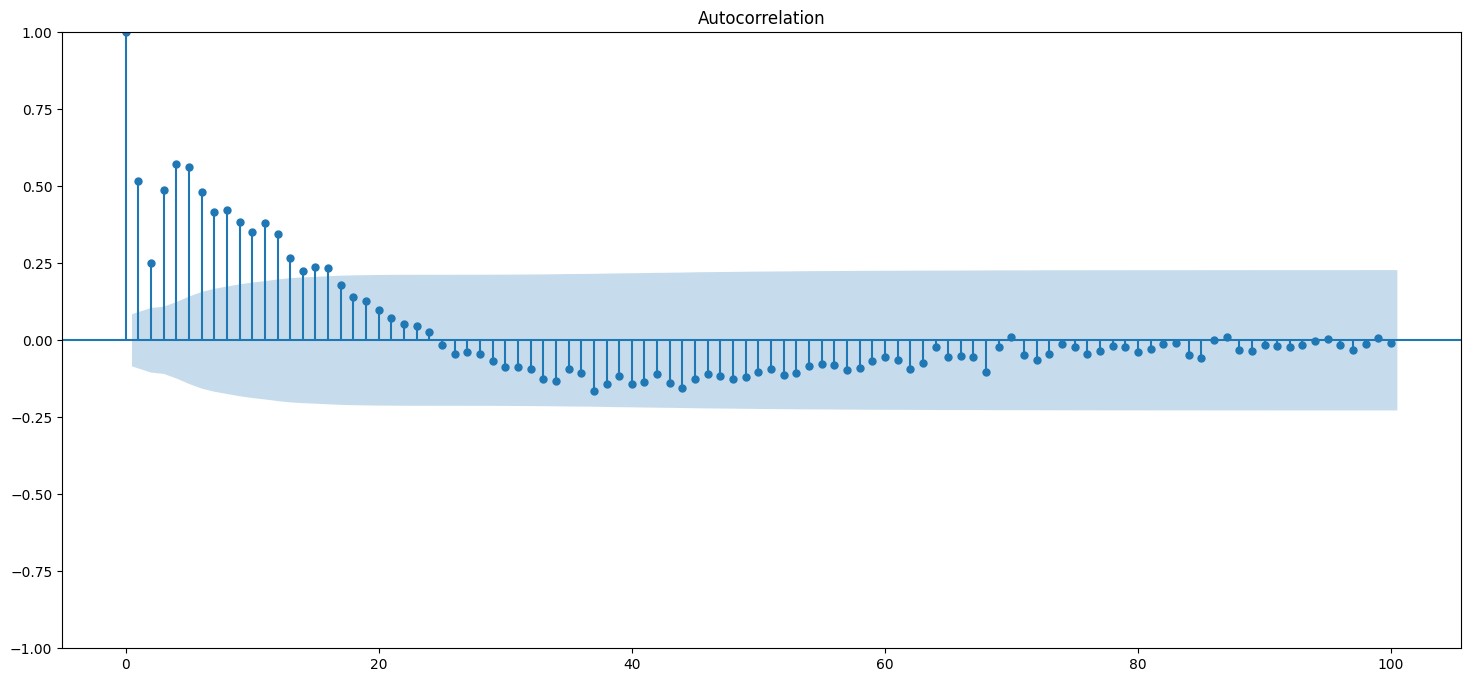

Convulucion 1/4 6


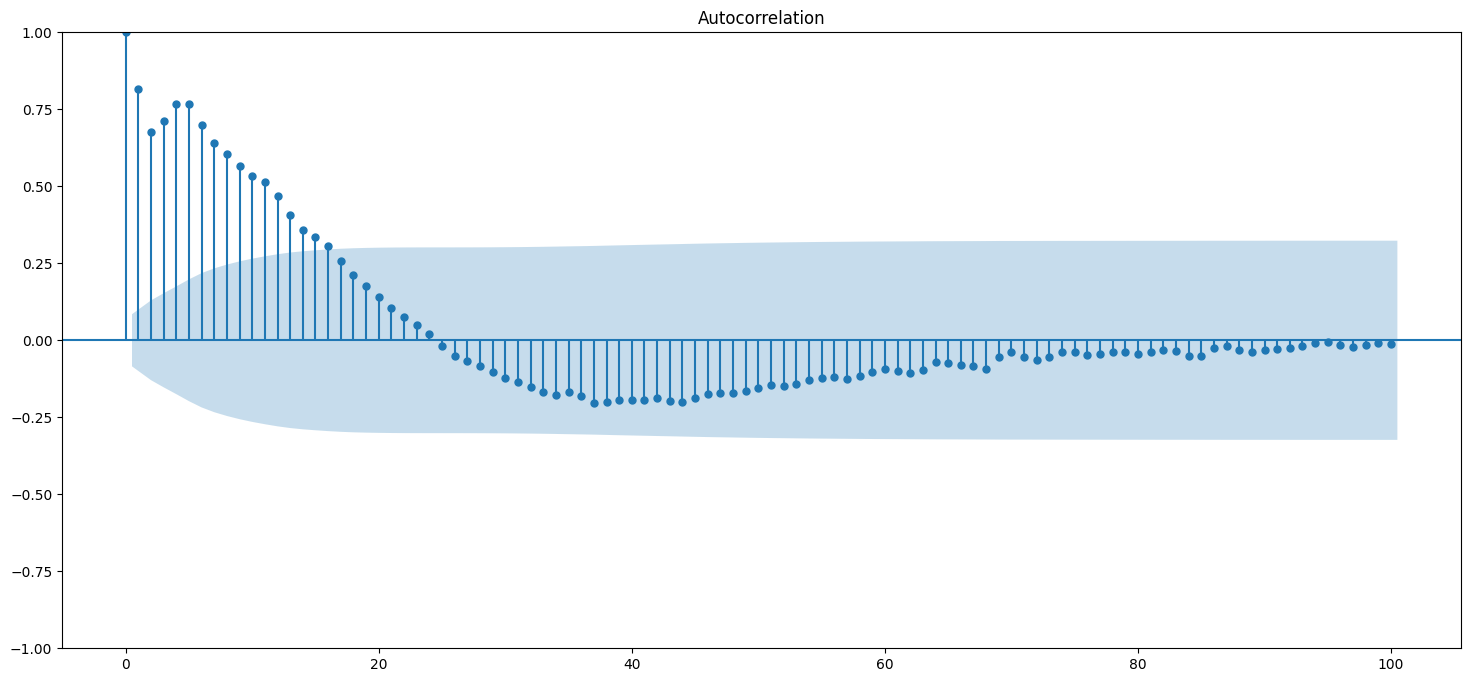

Convulucion 1/5 3


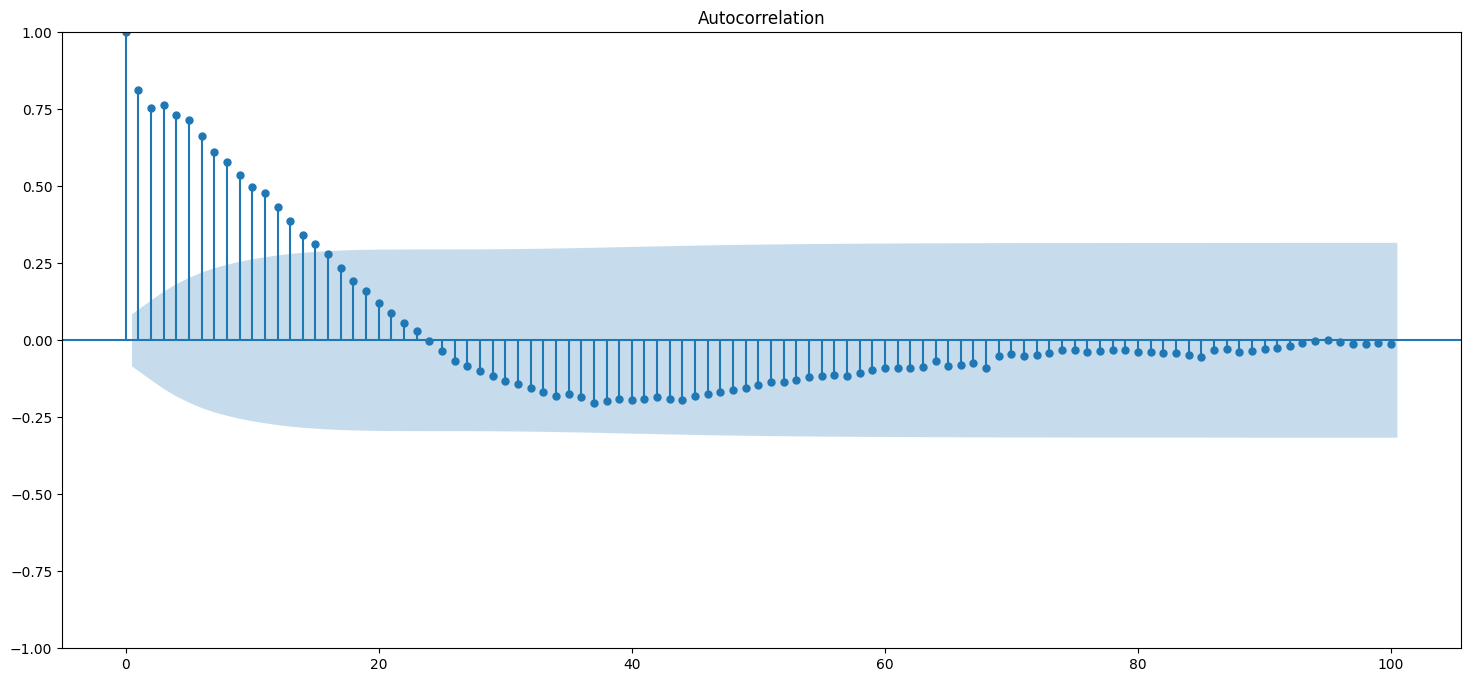

Convulucion 1/5 4


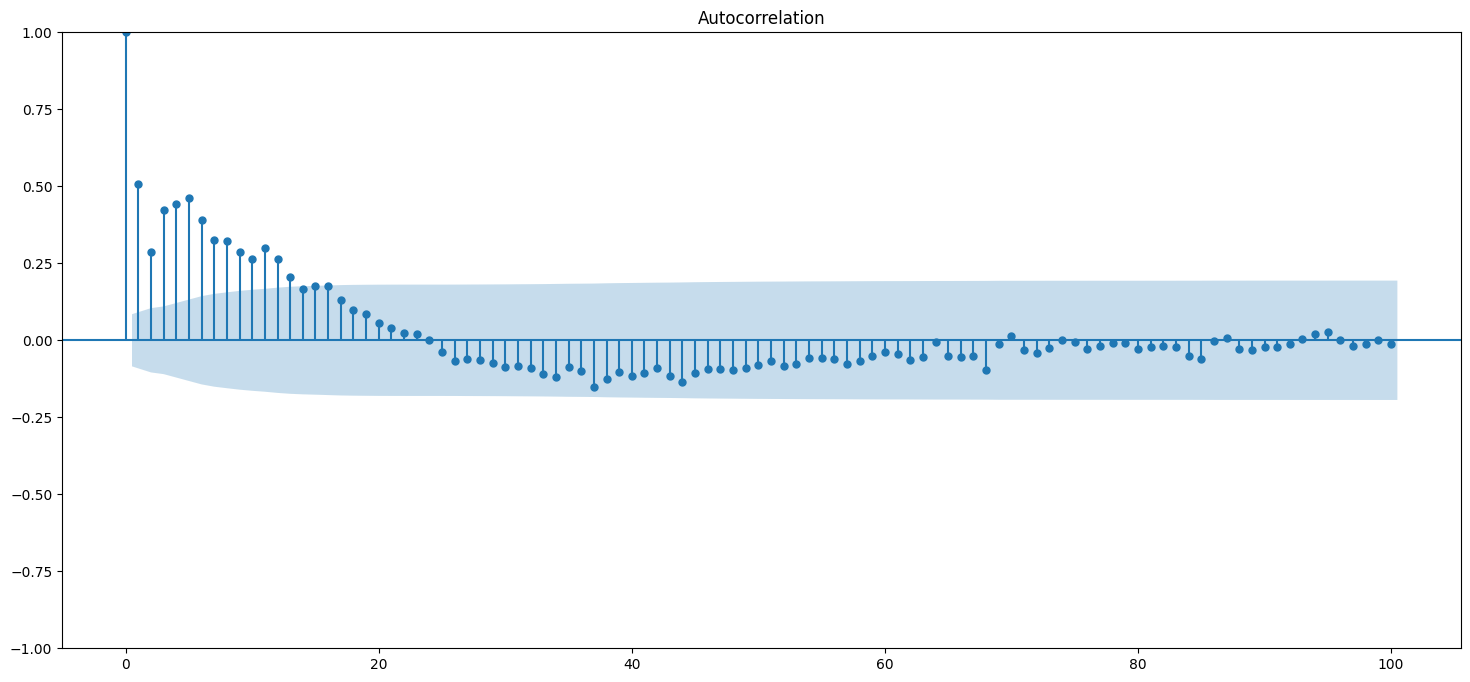

Convulucion 1/5 5


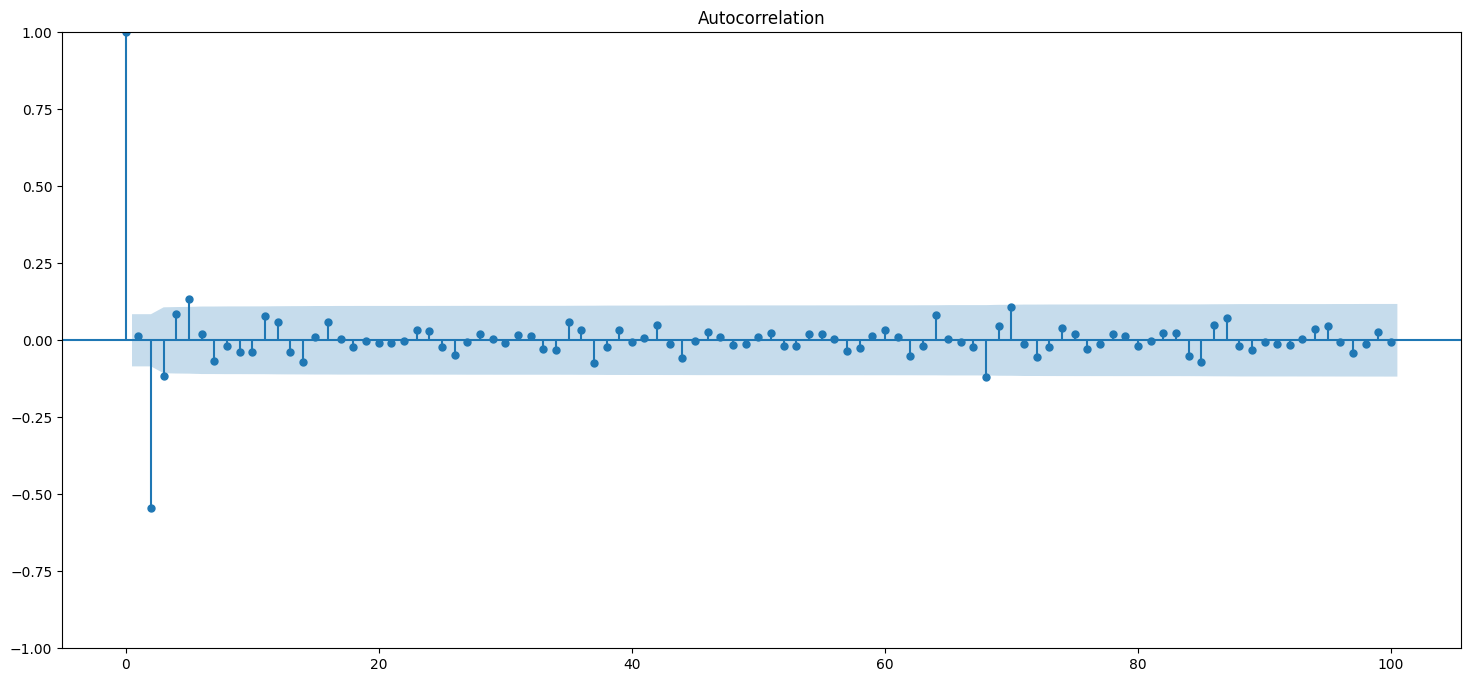

Convulucion 1/5 6


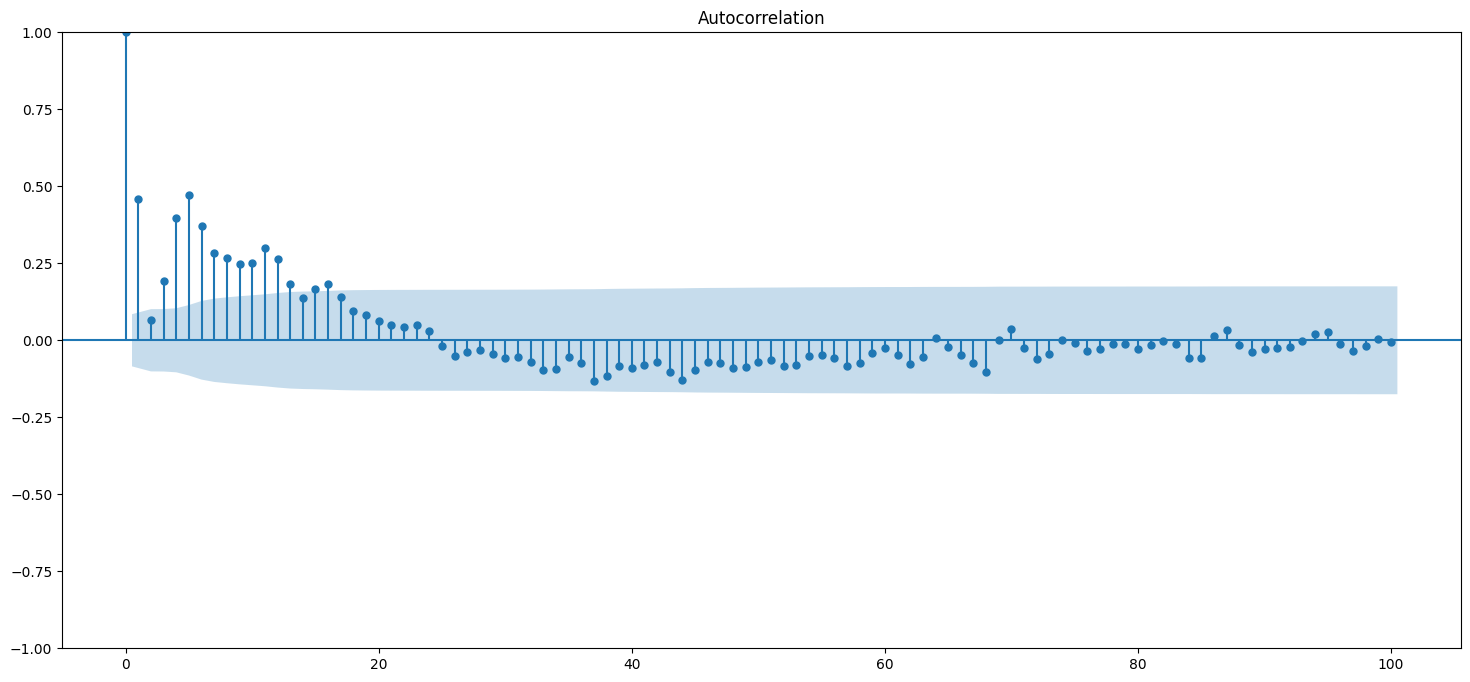

Convulucion 1/6 3


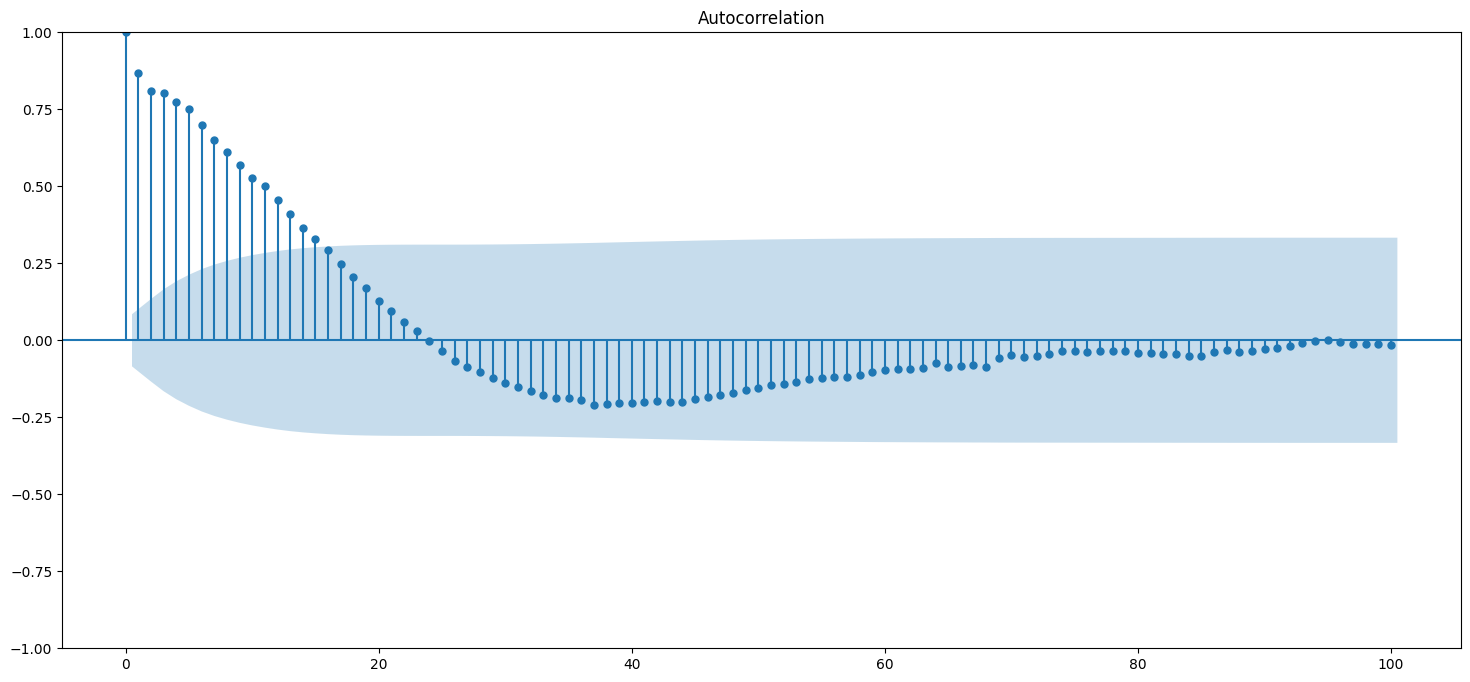

Convulucion 1/6 4


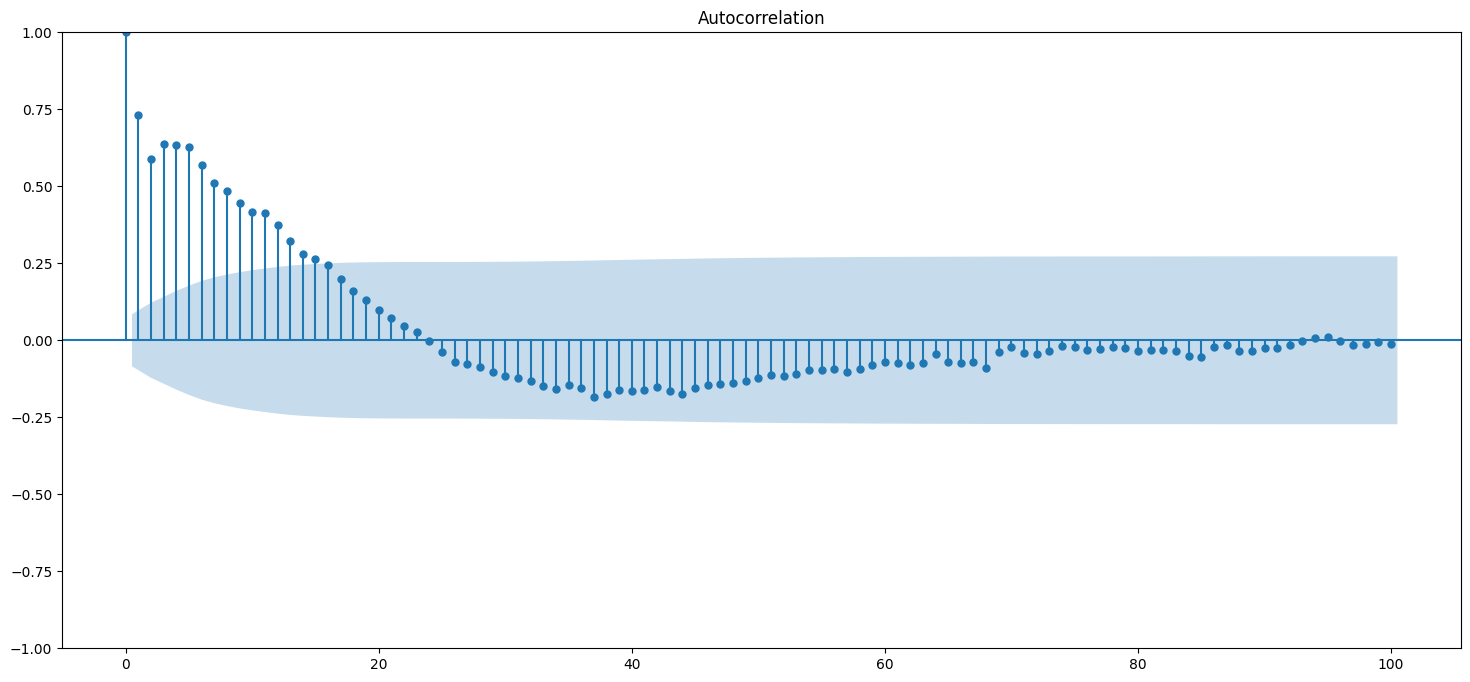

Convulucion 1/6 5


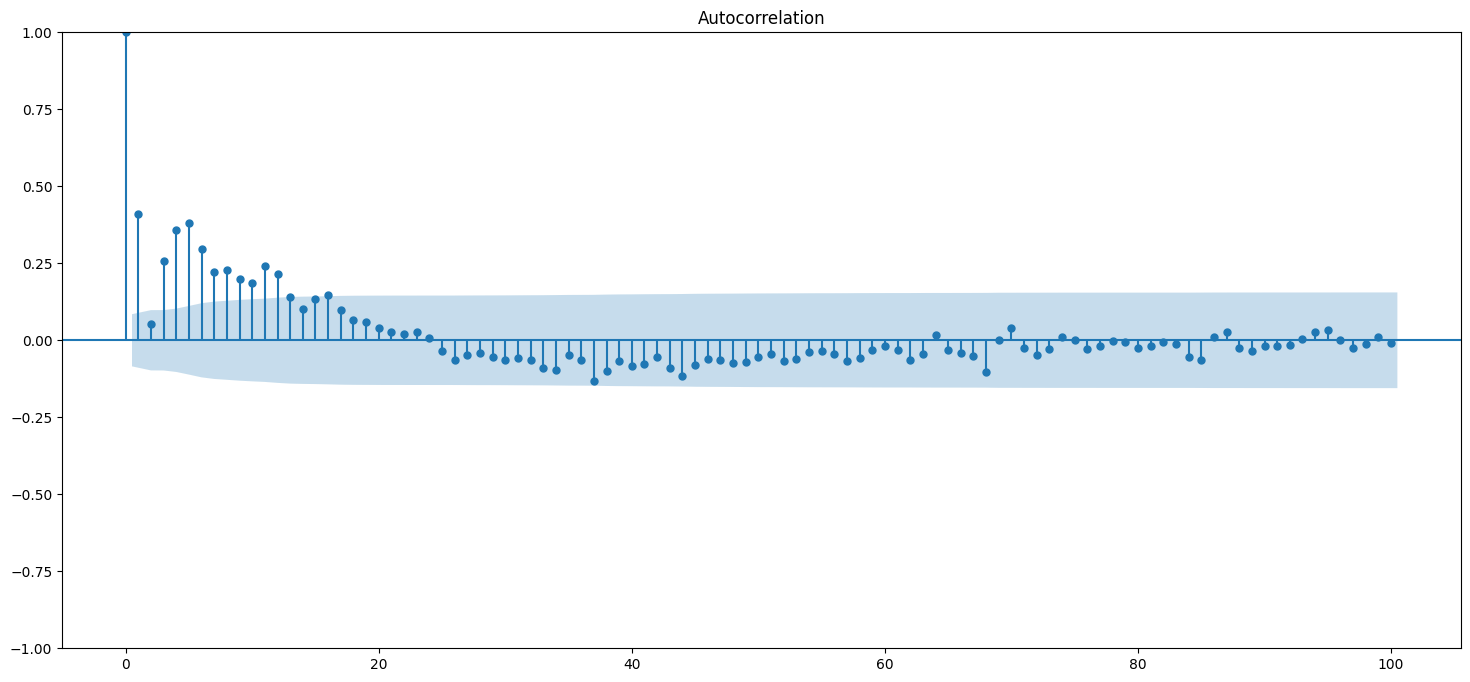

Convulucion 1/6 6


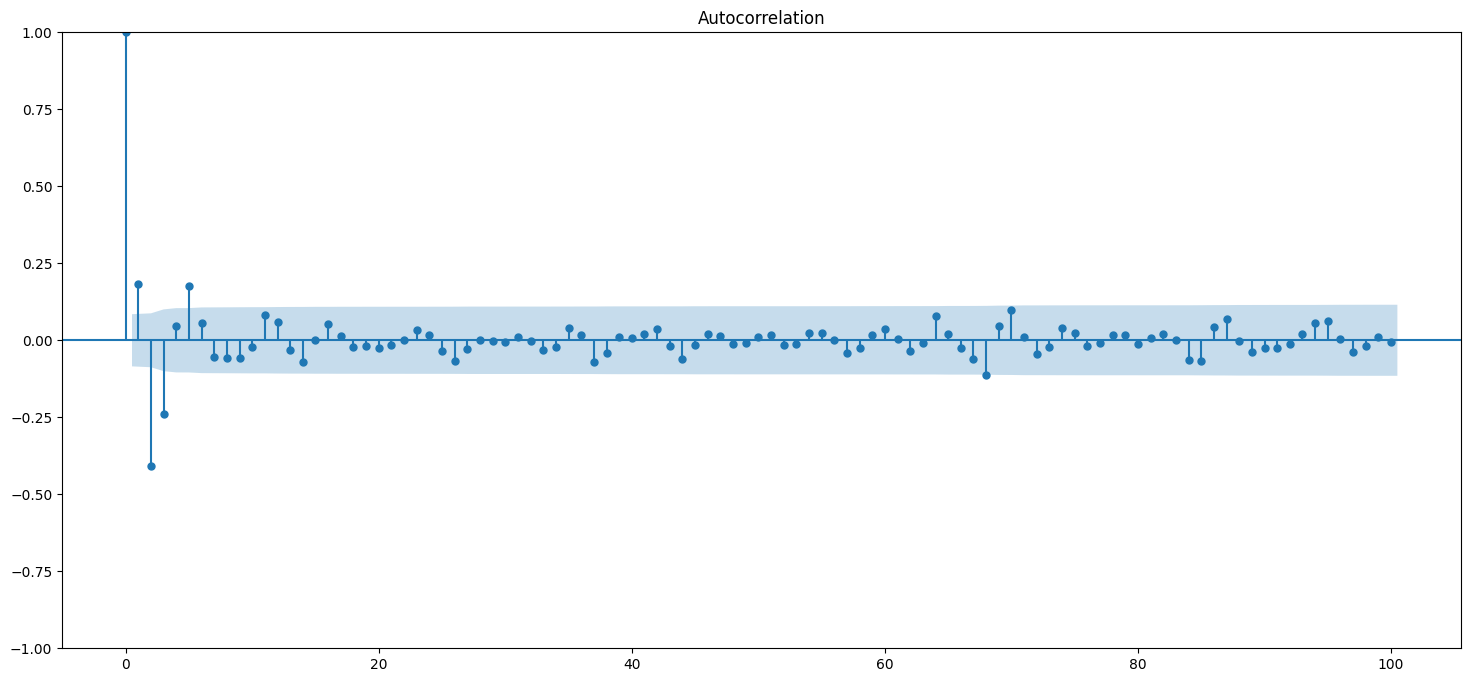

In [20]:
for i in range(1,7):
    for j in range(3,7):
        coeffs = np.repeat(1/i, j)
        filtered_signal = convolve(df_filters["W"], coeffs, mode='same')
        column_name= 'Con'+str(i)+str(j)
        df_filters[column_name]=df_filters["W"]-filtered_signal
        print(f"Convulucion 1/{i} {j}")
        fig=plot_acf(df_filters[column_name], lags=100)
        fig.set_size_inches(18.05, 8)
        plt.show()

In [21]:
ls_best= ["Con66","Con44","Con33"]

In [22]:
df_box= pd.DataFrame(columns=["Model", "lb_stat", "lb_pvalue"])
for model in ls_best:
    lags = 50
    test_results = sm.stats.acorr_ljungbox(df_filters[model], lags=lags, boxpierce=False, return_df=True)

    # Print test results
    test_results["Model"]= model
    df_box= pd.concat([df_box, test_results], ignore_index=True)

In [32]:
df_best=df_filters[['AuxDate', 'W']+ls_best ].copy()

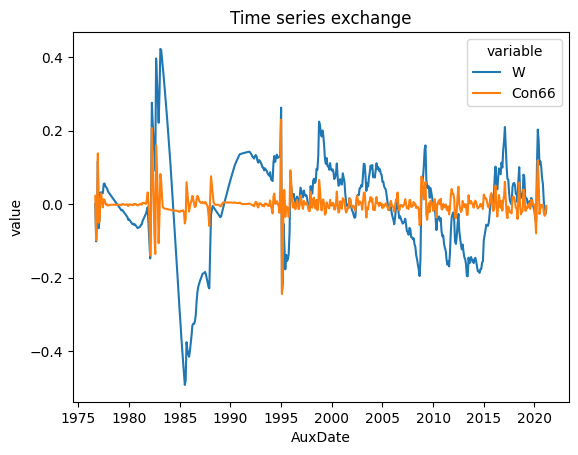

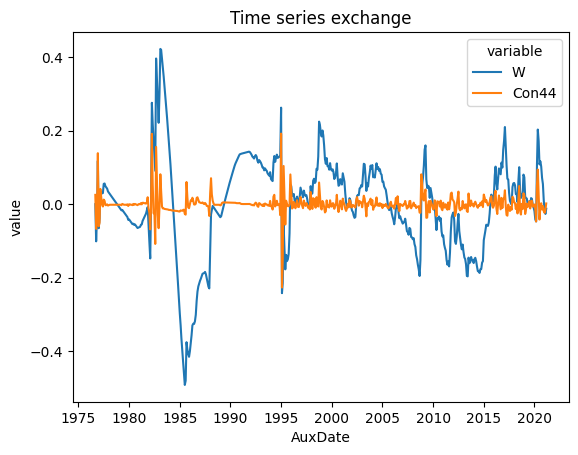

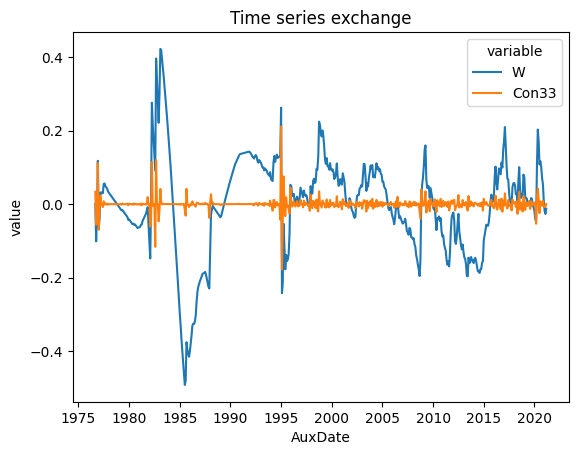

In [38]:
for model in ls_best: 
    g=sns.lineplot(x='AuxDate', y='value', hue='variable',data=pd.melt(df_best,id_vars=['AuxDate'],value_vars=["W", model] ))
    g.set(title='Time series exchange')
    plt.show()

In [23]:
df_box

,Model,lb_stat,lb_pvalue
0,Con66,18.199323,1.989496e-05
1,Con66,108.128354,3.313037e-24
2,Con66,139.476895,4.900600e-30
3,Con66,140.639558,2.059292e-29
4,Con66,157.562029,3.274001e-32
...,...,...,...
145,Con33,142.943841,7.185355e-12
146,Con33,142.979521,1.270315e-11
147,Con33,143.049110,2.196634e-11
148,Con33,143.050406,3.848416e-11
